# Clustering Estimated Perimenopausal Subset

Goal - Focus on Subgroup of Irregular Cyclers with Hot flashes, presuming these are peri-menopausal women

In [226]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy as scipy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [227]:
from sensorfabric.athena import athena

In [228]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [229]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [230]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [231]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [232]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Old Query; Ignore

In [ ]:
premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers NOT LIKE '%Hot Flashes/Night Sweats%'
            AND answers NOT LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            AND answers NOT LIKE '%Naturally%'
            AND answers NOT LIKE '%Medically%'
            AND answers NOT LIKE '%Hysterectomy%'
            AND answers NOT LIKE '%Chemotherapy%'
            )
            OR answers = 'Unpredictable'
            OR answers = 'Regular cycle'
            OR answers = 'none'
        )
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;
"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)

(8414, 3)


## Checking the actual onboarding responses to a simpler version of the query

In [233]:
premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded>10
        and symptoms_recorded<300
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)



(139829, 3)


In [210]:
#premenopausalusers_symptoms.to_csv('onboarding_perimenopausal_npt_check.csv')

## Ultrasimple Premenopause Query - Seems to filter out all menopausal answers. Still includes people with hot flashes which I will filter out later. This should be the "truest" premenopausal set


In [234]:

premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid,days_symptoms_recorded,symptoms_recorded 
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
       
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;
"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)

(40664, 3)


In [235]:
premenopausalusers_symptoms.head()

,uid,name,count
0,5f98bab244eca8ead4eca209,dry_eyes,4
1,5f98bab244eca8ead4eca209,spotting,3
2,5f98bab244eca8ead4eca209,brain_fog,2
3,5f98bab244eca8ead4eca209,nausea,1
4,5f98bab244eca8ead4eca209,fatigue,1


In [236]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(premenopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3052


In [237]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(premenopausalusers_symptoms['uid'].values, premenopausalusers_symptoms['name'].values, premenopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)


In [238]:
frame=frame.astype(int)

## Move Me Down After Users are Filtered One Hot Encording of Non Menopausal No Hot Flashes

In [ ]:
encoding = frame.copy(deep=True)
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0
encoding = encoding.applymap(replace_map)

encoding.to_csv('csv/symptoms_withhf_premenopause_onehot.csv', index=False)

## Diving a bit deeper into who is reporting hot flashes or night sweats in this group. (shravan pet project)

In [239]:
special = frame[(frame['hot_flashes'] > 0) | (frame['night_sweats'] > 0)]

In [240]:
print(special.shape)
print(frame.shape)
print(special.shape[0]/frame.shape[0])

(1936, 45)
(3051, 45)
0.634546050475254


~64% of the user who have been classified in the pre-menopause group report having hot flashes or night sweats.

There are 2,437 users 

In [218]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = special.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

hot_flashes: 12.63%
fatigue: 6.24%
headaches: 5.03%
cramps: 4.94%
night_sweats: 4.66%
bloating: 4.32%
anxiety: 4.27%
joint_pain: 3.38%
spotting: 3.34%
brain_fog: 3.08%
breast_pain: 2.92%
muscle_tension: 2.87%
mood_swings: 2.80%
allergies: 2.62%
insomnia: 2.59%
dry_skin: 2.48%
depression: 2.33%
dry_eyes: 2.19%
itchy_skin: 2.00%
dizzy: 1.75%
brittle_nails: 1.51%
facial_hair: 1.50%
nausea: 1.42%
chills: 1.40%
sex_drive: 1.38%
constipation: 1.34%
diarrhea: 1.30%
incontinence: 1.29%
memory_lapse: 1.28%
hair_loss: 1.28%
tingling_extremeties: 1.27%
irregular_beat: 1.26%
ringing_ears: 1.25%
heartburn: 1.07%
breast_swelling: 1.04%
odor: 0.97%
vaginal_dryness: 0.76%
ovulation_pain: 0.57%
vertigo: 0.46%
ovulation: 0.27%
vomiting: 0.27%
yeast_infection: 0.23%
painful_intercourse: 0.20%
uti: 0.18%
nipple_discharge: 0.08%


# Get the symptom breakdown by the (period = unpredictable, period = regular)

### Unpredictable

In [241]:
import utils
unpredictable_uids = db.execQuery('select uid from premeno_period_unpredictable', cached=True) #ok i guess we had a table called that already...convenient

In [242]:
unpredictable = frame[frame.index.isin(unpredictable_uids['uid'].values)]

In [243]:
utils.symPercentages(unpredictable)

hot_flashes: 11.27%
fatigue: 6.67%
cramps: 4.91%
headaches: 4.88%
bloating: 4.70%
spotting: 4.49%
anxiety: 4.39%
night_sweats: 3.63%
joint_pain: 3.50%
brain_fog: 3.16%
muscle_tension: 2.96%
breast_pain: 2.90%
mood_swings: 2.86%
allergies: 2.75%
dry_skin: 2.53%
depression: 2.44%
insomnia: 2.37%
itchy_skin: 2.12%
dry_eyes: 2.08%
dizzy: 1.75%
facial_hair: 1.57%
brittle_nails: 1.56%
hair_loss: 1.47%
memory_lapse: 1.43%
sex_drive: 1.43%
constipation: 1.36%
ringing_ears: 1.34%
nausea: 1.32%
diarrhea: 1.29%
incontinence: 1.28%
tingling_extremeties: 1.26%
chills: 1.26%
breast_swelling: 1.07%
irregular_beat: 1.04%
heartburn: 1.02%
odor: 0.91%
vaginal_dryness: 0.79%
ovulation_pain: 0.56%
vertigo: 0.49%
ovulation: 0.25%
vomiting: 0.22%
uti: 0.21%
yeast_infection: 0.21%
painful_intercourse: 0.21%
nipple_discharge: 0.09%


In [244]:
unpredictablewvms = special[special.index.isin(unpredictable_uids['uid'].values)]

In [245]:
#Save out these IDs

# Get UIDs from the unpredictablewvms 
uids = unpredictablewvms.index.tolist()

# Create DFe with the UIDs
uids_df = pd.DataFrame(uids, columns=['UID'])

# name it
csv_filename = 'perimenopause_uids.csv'

# Save the df  as a CSV file
uids_df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' has been created with {len(uids_df)} UIDs.")

CSV file 'perimenopause_uids.csv' has been created with 1388 UIDs.


In [246]:
utils.symPercentages(unpredictablewvms)

hot_flashes: 14.78%
fatigue: 6.33%
headaches: 4.77%
night_sweats: 4.77%
cramps: 4.38%
bloating: 4.26%
anxiety: 4.15%
joint_pain: 3.36%
spotting: 3.26%
brain_fog: 3.02%
muscle_tension: 3.02%
mood_swings: 2.74%
allergies: 2.58%
breast_pain: 2.49%
dry_skin: 2.49%
insomnia: 2.46%
depression: 2.28%
dry_eyes: 2.05%
itchy_skin: 2.04%
dizzy: 1.73%
facial_hair: 1.54%
brittle_nails: 1.51%
chills: 1.39%
incontinence: 1.34%
nausea: 1.33%
hair_loss: 1.32%
sex_drive: 1.32%
memory_lapse: 1.31%
ringing_ears: 1.31%
diarrhea: 1.29%
constipation: 1.25%
tingling_extremeties: 1.22%
heartburn: 1.07%
irregular_beat: 1.04%
odor: 0.93%
breast_swelling: 0.92%
vaginal_dryness: 0.80%
ovulation_pain: 0.52%
vertigo: 0.46%
vomiting: 0.25%
yeast_infection: 0.23%
painful_intercourse: 0.22%
uti: 0.20%
ovulation: 0.17%
nipple_discharge: 0.10%


### All Regular

In [23]:
regular_uids = db.execQuery('select uid from premeno_period_regular', cached=True)
regular = frame[frame.index.isin(regular_uids['uid'].values)]
utils.symPercentages(regular)

fatigue: 6.71%
bloating: 6.10%
cramps: 5.65%
headaches: 5.55%
hot_flashes: 4.23%
anxiety: 4.13%
allergies: 3.83%
joint_pain: 3.83%
breast_pain: 3.54%
dry_skin: 3.38%
dry_eyes: 3.36%
brain_fog: 3.36%
spotting: 3.16%
muscle_tension: 2.84%
night_sweats: 2.69%
mood_swings: 2.56%
insomnia: 2.45%
brittle_nails: 2.32%
ringing_ears: 2.20%
depression: 2.02%
itchy_skin: 1.99%
sex_drive: 1.76%
constipation: 1.68%
dizzy: 1.67%
breast_swelling: 1.67%
diarrhea: 1.56%
hair_loss: 1.47%
nausea: 1.44%
facial_hair: 1.44%
irregular_beat: 1.39%
tingling_extremeties: 1.29%
incontinence: 1.27%
chills: 1.19%
odor: 1.18%
memory_lapse: 1.03%
heartburn: 0.99%
vaginal_dryness: 0.81%
ovulation_pain: 0.60%
vertigo: 0.46%
ovulation: 0.45%
yeast_infection: 0.22%
painful_intercourse: 0.19%
vomiting: 0.17%
uti: 0.13%
nipple_discharge: 0.05%


## Regularnovms and Regularwvms

In [24]:
regularnovms=regular[(regular['hot_flashes'] == 0) & (regular['night_sweats'] == 0)]

In [36]:
regularwvms=regular[(regular['hot_flashes'] > 0) | (regular['night_sweats'] > 0)]

## So now we have 3 groups we care about here

### all women who are not menopausal, all women who are additionally regular and display no hot flashes, and women who are not menopausal but irregular and DO have hot flasehs

#frame is all premeno (if not runing the line below to remove HFs);unpredictablewvms = putative perimenopausal; regularnovms. we also have unpredictable

In [247]:
#Let's Identify the number of UIDs in each group

#Now how many do I have who are unpredictable with VMS
unique_uids = unpredictablewvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Unpredictable with Vasomotor Symptoms:", unique_uids_size)


Size of Unpredictable with Vasomotor Symptoms: 1388


In [28]:
#Now how many do I have who are Regular with No VMS
unique_uids = regularnovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular with No Vasomotor Symptoms:", unique_uids_size)

Size of Regular with No Vasomotor Symptoms: 468


In [37]:
#Now how many do I have who are Regular with VMS
unique_uids = regularwvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular With Vasomotor Symptoms:", unique_uids_size)

Size of Regular With Vasomotor Symptoms: 685


## Back to removing the folks who had HF and NS

In [29]:
#Note some users are still reporting hot flashes. Remove them. 

framenovms = frame[(frame['hot_flashes'] == 0) & (frame['night_sweats'] == 0)]

In [30]:
#Now how many do I have left?

unique_uids = framenovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 1338


In [ ]:
framenovms.to_csv('premenopausalsymptoms_correct.csv')

In [31]:
framenovms.head()

,dry_eyes,spotting,brain_fog,breast_pain,vertigo,dry_skin,fatigue,chills,anxiety,nausea,...,heartburn,uti,yeast_infection,itchy_skin,cramps,ovulation_pain,dizzy,ovulation,nipple_discharge,vomiting
uid,,,,,,,,,,,,,,,,,,,,,
5f98bab244eca8ead4eca209,4,3,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5f9990d744eca8ead4eca2d5,0,0,3,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5f9aebc8b82e4d12e4a90e68,12,1,4,1,2,8,61,3,3,2,...,19,12,10,6,6,2,0,0,0,0
5f9b22b7d01db71874617a55,1,10,5,11,0,0,3,0,0,3,...,0,0,0,0,13,0,3,0,0,0
5f9b505bd01db71874617af4,6,0,1,0,0,1,0,0,5,0,...,2,0,0,1,3,0,5,0,0,0


In [32]:
framenovms.shape

(1338, 45)

In [33]:
data_type = framenovms[symptoms].dtypes

## Create One Hot Encoding for Network Analysis of Unpredictable w/ VMS

In [248]:
encoding = unpredictablewvms.copy(deep=True)
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0
encoding = encoding.applymap(replace_map)

encoding.to_csv('symptoms_perimeno_unpredictablewvms_onehot.csv', index=False)

## Focusing Narrowly on Unpredictable with vms What's the distribution of symptoms by UID, and total Number of symptoms?

In [249]:
total_symptom_count_per_uid = unpredictablewvms.sum(axis=1)

# Overall sum of all symptom counts
overall_total_symptom_count = total_symptom_count_per_uid.sum()

#print("Total symptom count per UID:")
#print(total_symptom_count_per_uid)

print("\nOverall total symptom count unpredictable w vms:")
print(overall_total_symptom_count)


Overall total symptom count unpredictable w vms:
57964


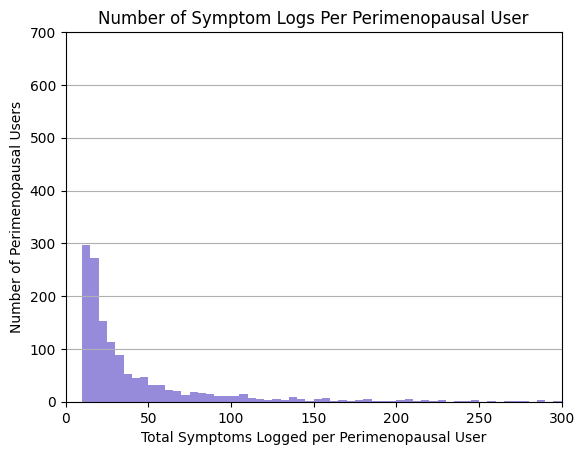

Median Symptoms per User: 23.0
Median Absolute Deviation (MAD) of Symptoms per User: 10.0


In [251]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = unpredictablewvms.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7,color=(106/255,90/255,205/255))
plt.xlabel('Total Symptoms Logged per Perimenopausal User')
plt.ylabel('Number of Perimenopausal Users')
plt.title('Number of Symptom Logs Per Perimenopausal User')
plt.grid(axis='y')
plt.ylim(0,700) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)


## Symptom Frequency by % of Total Symptoms, For Each Symptom

In [252]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = unpredictablewvms.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

hot_flashes: 14.78%
fatigue: 6.33%
headaches: 4.77%
night_sweats: 4.77%
cramps: 4.38%
bloating: 4.26%
anxiety: 4.15%
joint_pain: 3.36%
spotting: 3.26%
brain_fog: 3.02%
muscle_tension: 3.02%
mood_swings: 2.74%
allergies: 2.58%
breast_pain: 2.49%
dry_skin: 2.49%
insomnia: 2.46%
depression: 2.28%
dry_eyes: 2.05%
itchy_skin: 2.04%
dizzy: 1.73%
facial_hair: 1.54%
brittle_nails: 1.51%
chills: 1.39%
incontinence: 1.34%
nausea: 1.33%
hair_loss: 1.32%
sex_drive: 1.32%
memory_lapse: 1.31%
ringing_ears: 1.31%
diarrhea: 1.29%
constipation: 1.25%
tingling_extremeties: 1.22%
heartburn: 1.07%
irregular_beat: 1.04%
odor: 0.93%
breast_swelling: 0.92%
vaginal_dryness: 0.80%
ovulation_pain: 0.52%
vertigo: 0.46%
vomiting: 0.25%
yeast_infection: 0.23%
painful_intercourse: 0.22%
uti: 0.20%
ovulation: 0.17%
nipple_discharge: 0.10%


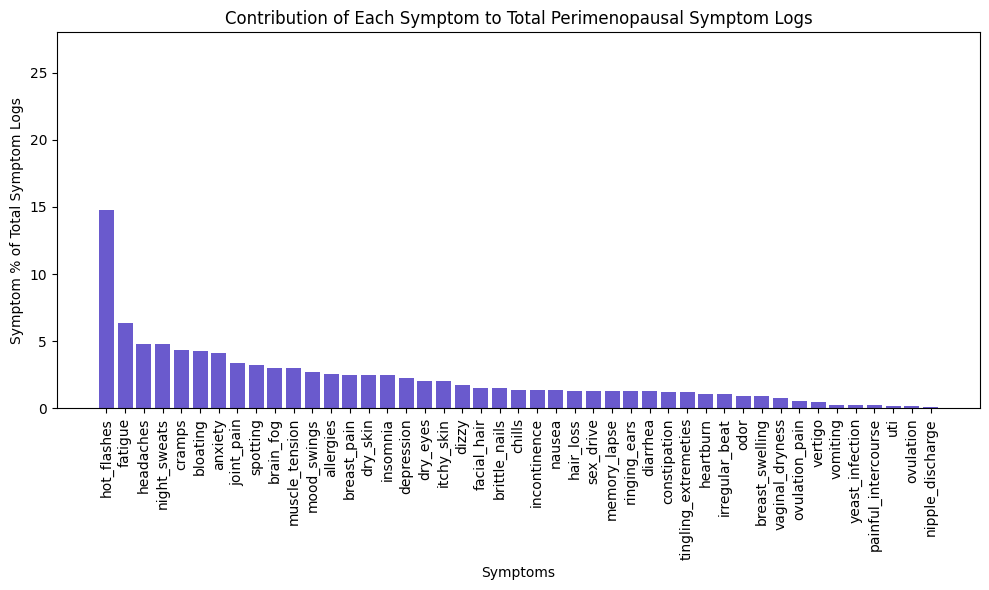

In [254]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(106/255,90/255,205/255))
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.ylim(0,28)
plt.title("Contribution of Each Symptom to Total Perimenopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Symptom Frequency by % of Users Reporting that Symptom

In [255]:
# Step 1: Calculate the total number of users
total_users = len(unpredictablewvms)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (unpredictablewvms.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

hot_flashes             83.357349
fatigue                 74.783862
night_sweats            62.175793
headaches               58.933718
bloating                57.132565
cramps                  54.899135
anxiety                 53.314121
brain_fog               51.224784
joint_pain              48.342939
mood_swings             46.829971
insomnia                45.965418
dry_skin                40.850144
muscle_tension          40.201729
depression              39.121037
itchy_skin              38.976945
allergies               37.824207
breast_pain             34.221902
spotting                33.645533
facial_hair             33.429395
memory_lapse            32.564841
brittle_nails           31.051873
dry_eyes                30.763689
dizzy                   30.691643
sex_drive               29.106628
nausea                  26.945245
hair_loss               26.873199
constipation            26.729107
tingling_extremeties    25.648415
chills                  25.360231
diarrhea      

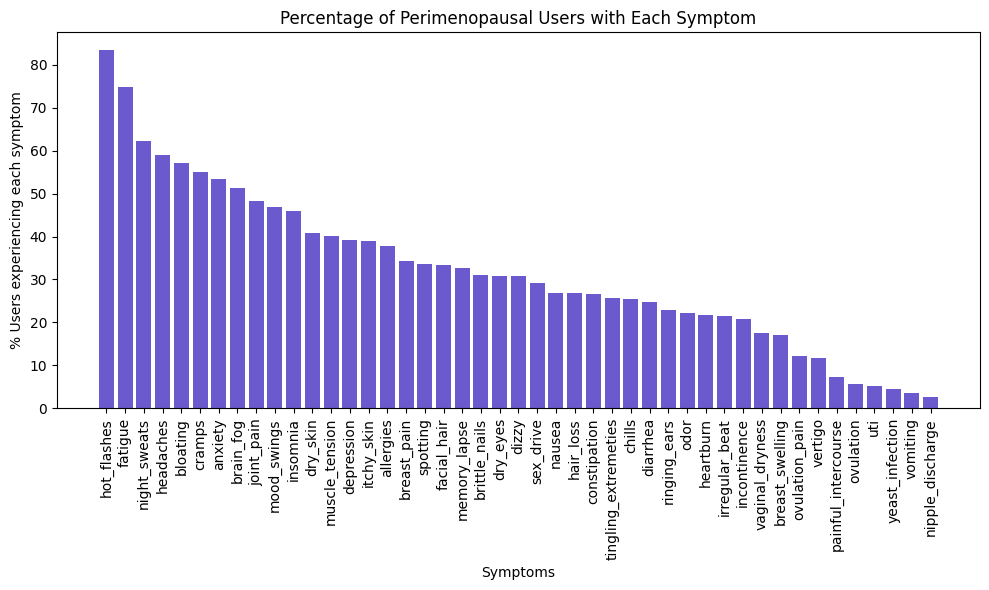

In [256]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(106/255,90/255,205/255))
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Perimenopausal Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [257]:
sframe = unpredictablewvms[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



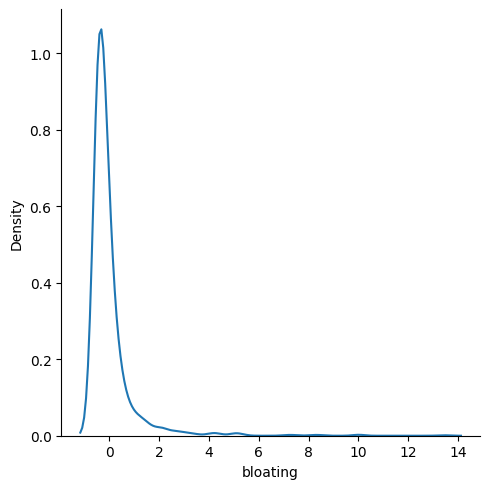

In [258]:
sns.displot(sframe, x='bloating', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



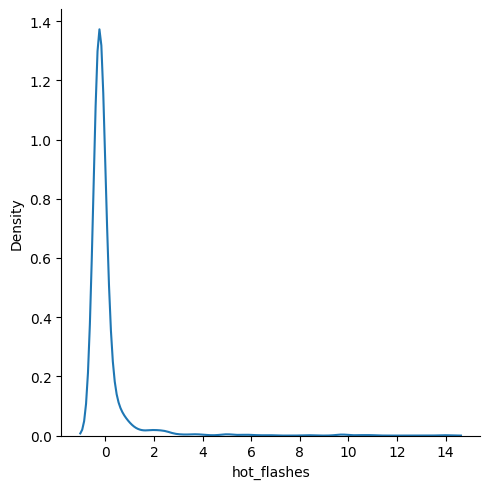

In [259]:
sns.displot(sframe, x='hot_flashes', kind='kde')

In [260]:
cmatrix = sframe.cov()

In [261]:
cmatrix.to_csv('perimeno_npt_symptom_covariance.csv', index=True)

In [262]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
#fig.write_image('figures/premeno__lenient_symptom_covariance.png')

In [163]:
#Alt covariance plot to properly display y axis titles

import plotly.graph_objs as go
import plotly.express as px

th = 0.6
fmatrix = cmatrix[cmatrix >= th]

# Step 1: Remove 'hot_flashes' and 'night_sweats' from the fmatrix
#fmatrix = fmatrix.drop(['hot_flashes', 'night_sweats'], axis=0)
#fmatrix = fmatrix.drop(['hot_flashes', 'night_sweats'], axis=1)

# Step 2: Sort the covariance matrix in descending order of covariance
sorted_cov_matrix = fmatrix.unstack().sort_values(ascending=False)

# Step 3: Create a bar graph to visualize the covariance by symptom pair
sorted_cov_matrix_df = sorted_cov_matrix.reset_index()
sorted_cov_matrix_df.columns = ['Symptom 1', 'Symptom 2', 'Covariance']

fig = px.bar(sorted_cov_matrix_df,
             x='Symptom 1',
             y='Covariance',
             text='Covariance',
             title='Symptom Covariance',
             labels={'Symptom 1': 'Symptom Pairs', 'Covariance': 'Covariance'},
             width=1024,
             height=600)
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability
fig.show()

# Step 4: Create a dictionary to store the counts of each symptom pair
symptom_pair_counts = {}

# Step 5: Iterate through the sorted DataFrame to count occurrences of each symptom pair
for _, row in sorted_cov_matrix_df.iterrows():
    symptom1 = row['Symptom 1']
    symptom2 = row['Symptom 2']
    covariance = row['Covariance']
    if not (symptom1 == symptom2):
        symptom_pair = f"{symptom1} - {symptom2}"
        count = fmatrix.loc[symptom1, symptom2]
        symptom_pair_counts[symptom_pair] = count

        
# Step 4: Print out the symptom pairs in order from highest to lowest covariance
for _, row in sorted_cov_matrix_df.iterrows():
    symptom1 = row['Symptom 1']
    symptom2 = row['Symptom 2']
    covariance = row['Covariance']
    if not (symptom1 == symptom2):
        print(f'{symptom1} - {symptom2} - {covariance}') #uncomment me to run

allergies - anxiety - nan
allergies - bloating - nan
allergies - brain_fog - nan
allergies - breast_pain - nan
allergies - breast_swelling - nan
allergies - brittle_nails - nan
allergies - chills - nan
allergies - constipation - nan
allergies - cramps - nan
allergies - depression - nan
allergies - diarrhea - nan
allergies - dizzy - nan
allergies - dry_eyes - nan
allergies - dry_skin - nan
allergies - facial_hair - nan
allergies - fatigue - nan
allergies - hair_loss - nan
allergies - headaches - nan
allergies - heartburn - nan
allergies - hot_flashes - nan
allergies - incontinence - nan
allergies - insomnia - nan
allergies - irregular_beat - nan
allergies - itchy_skin - nan
allergies - joint_pain - nan
allergies - memory_lapse - nan
allergies - mood_swings - nan
allergies - muscle_tension - nan
allergies - nausea - nan
allergies - night_sweats - nan
allergies - nipple_discharge - nan
allergies - odor - nan
allergies - ovulation - nan
allergies - ovulation_pain - nan
allergies - painful_

## Find pairs of symptoms with more than 80% corelation.

In [268]:
th=0.45

# Filter the covariance matrix based on the threshold
fmatrix = cmatrix[cmatrix >= th]

# Create a list of symptom pairs with their covariance values
covariance_list = []
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:
        paired = fmatrix[s].dropna().index.values
        for p in paired:
            if not (s == p):
                covariance = fmatrix.loc[s][p]
                covariance_list.append((s, p, covariance))

# Sort the list in descending order based on covariance values
sorted_covariance_list = sorted(covariance_list, key=lambda x: x[2], reverse=True)

# Print symptom pairs and their covariance values
for s1, s2, covariance in sorted_covariance_list:
    print('{} - {} - {}'.format(s1, s2, covariance))



fatigue - headaches - 0.5176540118299402
headaches - fatigue - 0.5176540118299402
sex_drive - yeast_infection - 0.5175607469288666
yeast_infection - sex_drive - 0.5175607469288666
joint_pain - muscle_tension - 0.4956872433785237
muscle_tension - joint_pain - 0.4956872433785237
anxiety - fatigue - 0.4801510820030404
fatigue - anxiety - 0.4801510820030404
dizzy - fatigue - 0.47518406402747204
fatigue - dizzy - 0.47518406402747204
brain_fog - memory_lapse - 0.45155888743757555
memory_lapse - brain_fog - 0.45155888743757555
cramps - spotting - 0.4509544722441102
spotting - cramps - 0.4509544722441102


In [166]:
import pandas as pd
import plotly.express as px

th = 0.4

fmatrix = cmatrix[cmatrix >= th]

# create the heatmap with the updated 'fmatrix'
fig = px.imshow(fmatrix,
                width=1024,
                height=1024,
                text_auto=True,
                aspect='auto',
                title='Symptom Covariance')
fig.show()

# Create an empty list to store the results
covariance_results = []

indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['hot_flashes', 'night_sweats']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and calculate the covariance and store the results in the list.
        for p in paired:
            if not (s == p):
                covariance = fmatrix.loc[s][p]
                covariance_results.append({'Symptom1': s, 'Symptom2': p, 'Covariance': covariance})

# Convert the list to a DataFrame
covariance_results_df = pd.DataFrame(covariance_results)

# Sort the DataFrame by the 'Covariance' column in descending order
covariance_results_df = covariance_results_df.sort_values(by='Covariance', ascending=False)

# Print the sorted results
print(covariance_results_df)


           Symptom1         Symptom2  Covariance
19        headaches          fatigue    0.497434
18          fatigue        headaches    0.497434
26   muscle_tension       joint_pain    0.485315
22       joint_pain   muscle_tension    0.485315
2           anxiety          fatigue    0.473444
14          fatigue          anxiety    0.473444
17          fatigue            dizzy    0.456106
11            dizzy          fatigue    0.456106
21       itchy_skin         dry_skin    0.455966
13         dry_skin       itchy_skin    0.455966
7         brain_fog      mood_swings    0.453139
24      mood_swings        brain_fog    0.453139
5         brain_fog          fatigue    0.452420
16          fatigue        brain_fog    0.452420
1           anxiety       depression    0.436080
10       depression          anxiety    0.436080
4          bloating          fatigue    0.431834
15          fatigue         bloating    0.431834
20        headaches   muscle_tension    0.428843
25   muscle_tension 

### Notes

With super users filtered out -- there are MUCH weaker pairwise correlations.

## Cluster Map

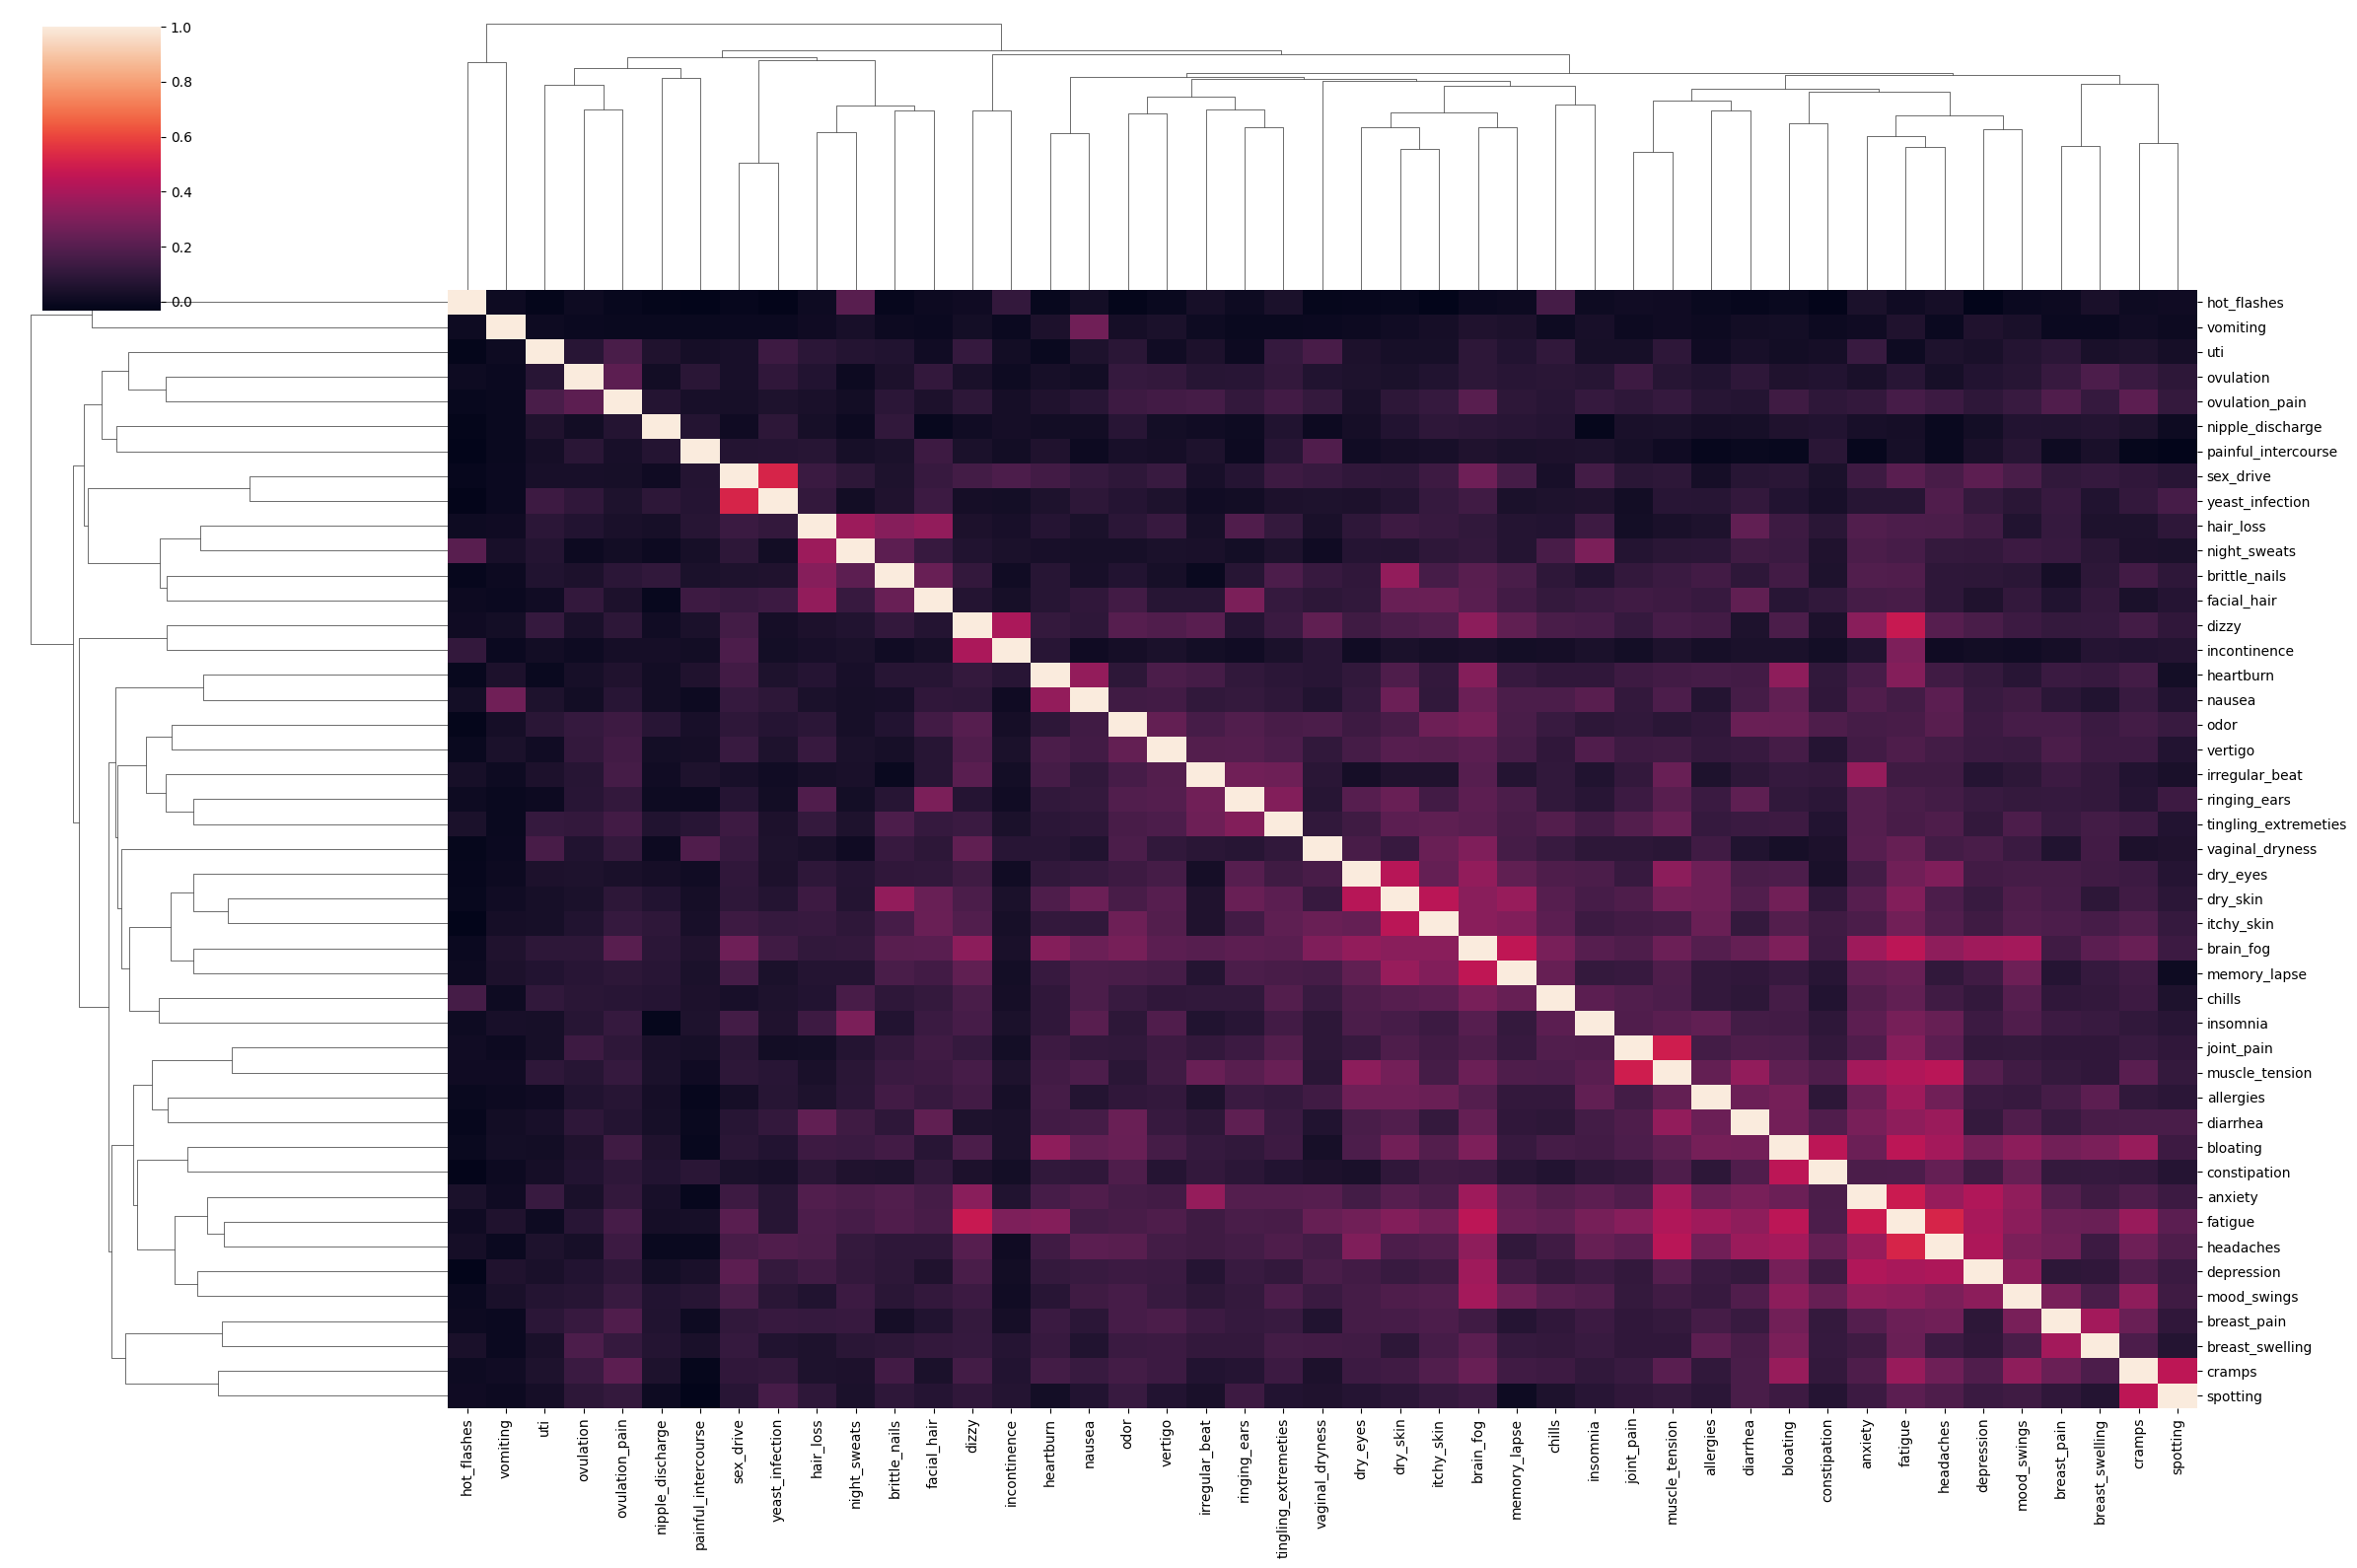

In [269]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [270]:
#Note nothing to see from ARI or DBS. We don't have predetermined labels to compare to. 

# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [271]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)


Optimal number of clusters: 2


In [272]:
hcluster.savefig('perimeno_npt_symptom_co_hirach.png')

## Perform PCA analysis on the data.

In [273]:
from sklearn.decomposition import PCA

In [274]:
pca = PCA(n_components=15, svd_solver='full')
X = unpredictablewvms[symptoms]

In [275]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [276]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [277]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.55, 0.55
PCA2 - 0.11, 0.66
PCA3 - 0.05, 0.71
PCA4 - 0.03, 0.74
PCA5 - 0.03, 0.77
PCA6 - 0.03, 0.79
PCA7 - 0.02, 0.81
PCA8 - 0.02, 0.83
PCA9 - 0.02, 0.85
PCA10 - 0.01, 0.86
PCA11 - 0.01, 0.87
PCA12 - 0.01, 0.88
PCA13 - 0.01, 0.90
PCA14 - 0.01, 0.90
PCA15 - 0.01, 0.91


Looks like we would need 8 principal components if we wanted to keep 91% of the variance. \
However the 2 components account for the majority of variance (71%), while an 80% variance is represented by 4 components.

In [278]:
pcacomponents = pca.fit_transform(X)

In [279]:
pcacomponents.shape

(1388, 15)

In [280]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [281]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

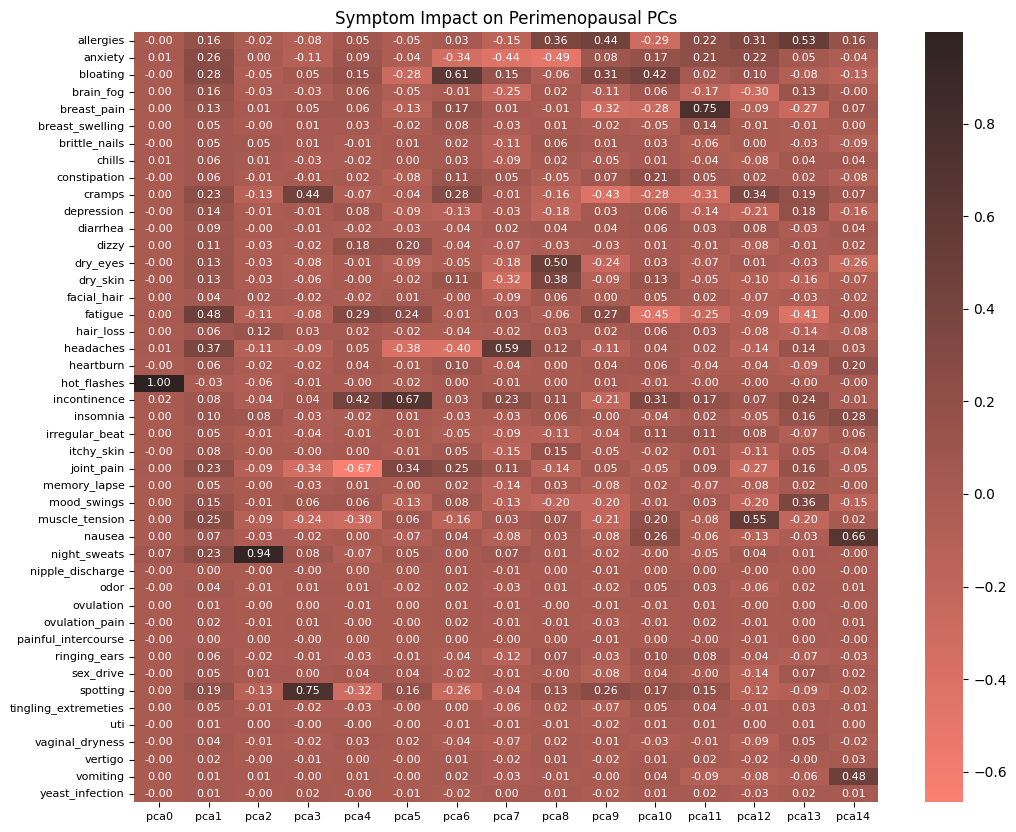

In [283]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Create a light palette with the color 'seagreen'
cmap=sns.color_palette("dark:salmon_r", as_cmap=True)

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using the custom colormap
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap=cmap, annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Perimenopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 90% variance

In [284]:
pca = PCA(n_components=13, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(1388, 13)

In [285]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [286]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

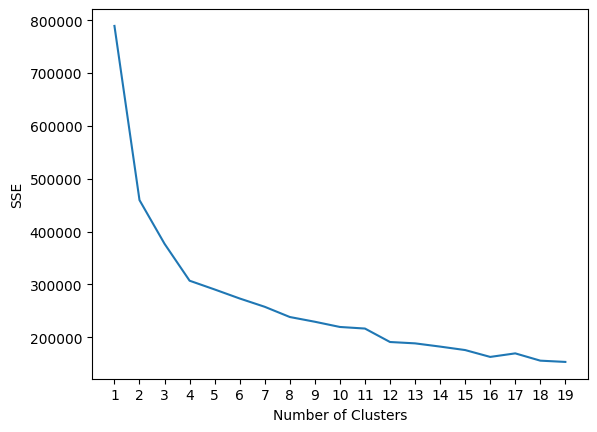

In [287]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [288]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **3**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [289]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

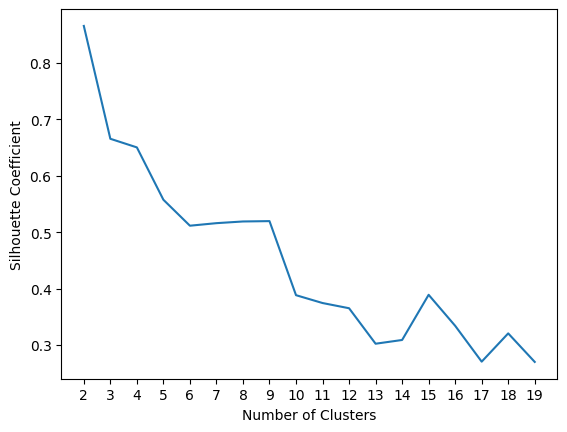

In [290]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [291]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - 

## Cluster them using k-means clustering

In [293]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 10
1 - 168
2 - 49
3 - 1128
4 - 33


## Get the users which belong to each of these clusters

In [294]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [296]:
def getTopSymptoms(users, top=5):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [298]:

## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [299]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [300]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['hot_flashes' 'night_sweats' 'incontinence' 'chills' 'headaches']
Segment 1
['fatigue' 'hot_flashes' 'cramps' 'headaches' 'spotting']
Segment 2
['hot_flashes' 'night_sweats' 'fatigue' 'anxiety' 'chills']
Segment 3
['hot_flashes' 'fatigue' 'night_sweats' 'cramps' 'bloating']
Segment 4
['fatigue' 'headaches' 'anxiety' 'muscle_tension' 'bloating']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

In [79]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 46
1 - 6
2 - 1486
Segment 0
['hot_flashes' 'night_sweats' 'chills' 'cramps' 'headaches' 'bloating'
 'fatigue' 'joint_pain' 'dry_eyes' 'brain_fog']
Segment 1
['hot_flashes' 'incontinence' 'chills' 'night_sweats' 'headaches'
 'muscle_tension' 'joint_pain' 'diarrhea' 'anxiety' 'insomnia']
Segment 2
['hot_flashes' 'fatigue' 'bloating' 'night_sweats' 'anxiety' 'headaches'
 'cramps' 'joint_pain' 'brain_fog' 'dry_skin']


# Clustering Perimenopausal Subset

Goal - Focus on Subgroup of Irregular Cyclers with Hot flashes, presuming these are peri-menopausal women

In [134]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy as scipy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [135]:
from sensorfabric.athena import athena

In [136]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [137]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [138]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [7]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [141]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Old Query; Ignore

In [ ]:
premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers NOT LIKE '%Hot Flashes/Night Sweats%'
            AND answers NOT LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            AND answers NOT LIKE '%Naturally%'
            AND answers NOT LIKE '%Medically%'
            AND answers NOT LIKE '%Hysterectomy%'
            AND answers NOT LIKE '%Chemotherapy%'
            )
            OR answers = 'Unpredictable'
            OR answers = 'Regular cycle'
            OR answers = 'none'
        )
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;
"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)

(8414, 3)


## Checking the actual onboarding responses to a simpler version of the query

In [10]:
premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded>10
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)



(178193, 3)


In [ ]:
premenopausalusers_symptoms.to_csv('onboarding_perimenopausal_check.csv')

## Ultrasimple Premenopause Query - Seems to filter out all menopausal answers. Still includes people with hot flashes which I will filter out later. This should be the "truest" premenopausal set


In [142]:

premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid,days_symptoms_recorded,symptoms_recorded 
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
       
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;
"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)

(49541, 3)


In [143]:
premenopausalusers_symptoms.head()

,uid,name,count
0,5f98bab244eca8ead4eca209,dry_eyes,4
1,5f98bab244eca8ead4eca209,spotting,3
2,5f98bab244eca8ead4eca209,brain_fog,2
3,5f98bab244eca8ead4eca209,nausea,1
4,5f98bab244eca8ead4eca209,fatigue,1


In [144]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(premenopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3702


In [145]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(premenopausalusers_symptoms['uid'].values, premenopausalusers_symptoms['name'].values, premenopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)


In [146]:
frame=frame.astype(int)

## One Hot Encording of Non Menopausal No Hot Flashes

In [ ]:
encoding = frame.copy(deep=True)
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0
encoding = encoding.applymap(replace_map)

encoding.to_csv('csv/symptoms_withhf_premenopause_onehot.csv', index=False)

## Diving a bit deeper into who is reporting hot flashes or night sweats in this group. (shravan pet project)

?Shravan - How many people who we classified as pre-menopausal also report classic memopause symptoms like hot-flashes and night sweats.

In [147]:
special = frame[(frame['hot_flashes'] > 0) | (frame['night_sweats'] > 0)]

In [148]:
print(special.shape)
print(frame.shape)
print(special.shape[0]/frame.shape[0])

(2367, 45)
(3701, 45)
0.6395568765198595


~64% of the user who have been classified in the pre-menopause group report having hot flashes or night sweats.

There are 2,437 users 

In [149]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = special.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

hot_flashes: 12.64%
fatigue: 6.09%
cramps: 4.99%
headaches: 4.99%
night_sweats: 4.72%
bloating: 4.59%
anxiety: 4.14%
joint_pain: 3.34%
spotting: 3.16%
brain_fog: 3.07%
allergies: 2.85%
breast_pain: 2.82%
muscle_tension: 2.73%
mood_swings: 2.72%
dry_skin: 2.61%
insomnia: 2.54%
dry_eyes: 2.37%
depression: 2.27%
itchy_skin: 1.98%
dizzy: 1.68%
facial_hair: 1.65%
brittle_nails: 1.65%
sex_drive: 1.48%
constipation: 1.37%
chills: 1.35%
nausea: 1.34%
hair_loss: 1.32%
incontinence: 1.30%
ringing_ears: 1.27%
diarrhea: 1.27%
tingling_extremeties: 1.25%
memory_lapse: 1.24%
irregular_beat: 1.16%
breast_swelling: 1.03%
odor: 1.01%
heartburn: 1.00%
vaginal_dryness: 0.78%
ovulation_pain: 0.57%
vertigo: 0.47%
ovulation: 0.28%
vomiting: 0.24%
yeast_infection: 0.22%
painful_intercourse: 0.21%
uti: 0.17%
nipple_discharge: 0.07%


# Get the symptom breakdown by the (period = unpredictable, period = regular)

### Unpredictable

In [150]:
import utils
unpredictable_uids = db.execQuery('select uid from premeno_period_unpredictable', cached=True) #ok i guess we had a table called that already...convenient

In [94]:
unpredictable = frame[frame.index.isin(unpredictable_uids['uid'].values)]

In [95]:
utils.symPercentages(unpredictable)

hot_flashes: 11.42%
fatigue: 6.50%
bloating: 5.00%
headaches: 4.88%
cramps: 4.88%
anxiety: 4.27%
spotting: 4.16%
night_sweats: 3.71%
joint_pain: 3.48%
brain_fog: 3.14%
allergies: 3.00%
breast_pain: 2.85%
muscle_tension: 2.80%
mood_swings: 2.76%
dry_skin: 2.68%
dry_eyes: 2.34%
depression: 2.33%
insomnia: 2.32%
itchy_skin: 2.07%
brittle_nails: 1.73%
dizzy: 1.70%
facial_hair: 1.63%
hair_loss: 1.48%
sex_drive: 1.46%
constipation: 1.37%
memory_lapse: 1.37%
ringing_ears: 1.33%
incontinence: 1.27%
tingling_extremeties: 1.25%
diarrhea: 1.25%
nausea: 1.25%
chills: 1.24%
breast_swelling: 1.06%
heartburn: 1.01%
irregular_beat: 0.98%
odor: 0.94%
vaginal_dryness: 0.82%
ovulation_pain: 0.58%
vertigo: 0.50%
ovulation: 0.26%
painful_intercourse: 0.22%
uti: 0.21%
yeast_infection: 0.21%
vomiting: 0.20%
nipple_discharge: 0.08%


In [151]:
unpredictablewvms = special[special.index.isin(unpredictable_uids['uid'].values)]

In [199]:
#Save out these IDs

# Get UIDs from the unpredictablewvms 
uids = unpredictablewvms.index.tolist()

# Create DFe with the UIDs
uids_df = pd.DataFrame(uids, columns=['UID'])

# name it
csv_filename = 'perimenopause_uids.csv'

# Save the df  as a CSV file
uids_df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' has been created with {len(uids_df)} UIDs.")

CSV file 'perimenopause_uids.csv' has been created with 1699 UIDs.


In [152]:
utils.symPercentages(unpredictablewvms)

hot_flashes: 14.88%
fatigue: 6.14%
night_sweats: 4.83%
headaches: 4.74%
bloating: 4.55%
cramps: 4.38%
anxiety: 4.01%
joint_pain: 3.27%
spotting: 3.09%
brain_fog: 3.04%
allergies: 2.82%
muscle_tension: 2.82%
mood_swings: 2.65%
dry_skin: 2.63%
breast_pain: 2.44%
insomnia: 2.38%
dry_eyes: 2.32%
depression: 2.18%
itchy_skin: 2.01%
brittle_nails: 1.69%
dizzy: 1.68%
facial_hair: 1.63%
sex_drive: 1.37%
hair_loss: 1.37%
chills: 1.35%
incontinence: 1.32%
ringing_ears: 1.32%
memory_lapse: 1.27%
nausea: 1.26%
constipation: 1.25%
diarrhea: 1.22%
tingling_extremeties: 1.22%
heartburn: 1.02%
odor: 0.96%
irregular_beat: 0.96%
breast_swelling: 0.90%
vaginal_dryness: 0.83%
ovulation_pain: 0.55%
vertigo: 0.48%
painful_intercourse: 0.23%
yeast_infection: 0.22%
vomiting: 0.22%
uti: 0.20%
ovulation: 0.20%
nipple_discharge: 0.09%


### All Regular

In [23]:
regular_uids = db.execQuery('select uid from premeno_period_regular', cached=True)
regular = frame[frame.index.isin(regular_uids['uid'].values)]
utils.symPercentages(regular)

fatigue: 6.71%
bloating: 6.10%
cramps: 5.65%
headaches: 5.55%
hot_flashes: 4.23%
anxiety: 4.13%
allergies: 3.83%
joint_pain: 3.83%
breast_pain: 3.54%
dry_skin: 3.38%
dry_eyes: 3.36%
brain_fog: 3.36%
spotting: 3.16%
muscle_tension: 2.84%
night_sweats: 2.69%
mood_swings: 2.56%
insomnia: 2.45%
brittle_nails: 2.32%
ringing_ears: 2.20%
depression: 2.02%
itchy_skin: 1.99%
sex_drive: 1.76%
constipation: 1.68%
dizzy: 1.67%
breast_swelling: 1.67%
diarrhea: 1.56%
hair_loss: 1.47%
nausea: 1.44%
facial_hair: 1.44%
irregular_beat: 1.39%
tingling_extremeties: 1.29%
incontinence: 1.27%
chills: 1.19%
odor: 1.18%
memory_lapse: 1.03%
heartburn: 0.99%
vaginal_dryness: 0.81%
ovulation_pain: 0.60%
vertigo: 0.46%
ovulation: 0.45%
yeast_infection: 0.22%
painful_intercourse: 0.19%
vomiting: 0.17%
uti: 0.13%
nipple_discharge: 0.05%


## Regularnovms and Regularwvms

In [24]:
regularnovms=regular[(regular['hot_flashes'] == 0) & (regular['night_sweats'] == 0)]

In [36]:
regularwvms=regular[(regular['hot_flashes'] > 0) | (regular['night_sweats'] > 0)]

## So now we have 3 groups we care about here

### all women who are not menopausal, all women who are additionally regular and display no hot flashes, and women who are not menopausal but irregular and DO have hot flasehs

#frame is all premeno (if not runing the line below to remove HFs);unpredictablewvms = putative perimenopausal; regularnovms. we also have unpredictable

In [153]:
#Let's Identify the number of UIDs in each group

#Now how many do I have who are unpredictable with VMS
unique_uids = unpredictablewvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Unpredictable with Vasomotor Symptoms:", unique_uids_size)


Size of Unpredictable with Vasomotor Symptoms: 1699


In [28]:
#Now how many do I have who are Regular with No VMS
unique_uids = regularnovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular with No Vasomotor Symptoms:", unique_uids_size)

Size of Regular with No Vasomotor Symptoms: 468


In [37]:
#Now how many do I have who are Regular with VMS
unique_uids = regularwvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Regular With Vasomotor Symptoms:", unique_uids_size)

Size of Regular With Vasomotor Symptoms: 685


## Back to removing the folks who had HF and NS

In [29]:
#Note some users are still reporting hot flashes. Remove them. 

framenovms = frame[(frame['hot_flashes'] == 0) & (frame['night_sweats'] == 0)]

In [30]:
#Now how many do I have left?

unique_uids = framenovms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 1338


In [ ]:
framenovms.to_csv('premenopausalsymptoms_correct.csv')

In [31]:
framenovms.head()

,dry_eyes,spotting,brain_fog,breast_pain,vertigo,dry_skin,fatigue,chills,anxiety,nausea,...,heartburn,uti,yeast_infection,itchy_skin,cramps,ovulation_pain,dizzy,ovulation,nipple_discharge,vomiting
uid,,,,,,,,,,,,,,,,,,,,,
5f98bab244eca8ead4eca209,4,3,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5f9990d744eca8ead4eca2d5,0,0,3,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5f9aebc8b82e4d12e4a90e68,12,1,4,1,2,8,61,3,3,2,...,19,12,10,6,6,2,0,0,0,0
5f9b22b7d01db71874617a55,1,10,5,11,0,0,3,0,0,3,...,0,0,0,0,13,0,3,0,0,0
5f9b505bd01db71874617af4,6,0,1,0,0,1,0,0,5,0,...,2,0,0,1,3,0,5,0,0,0


In [32]:
framenovms.shape

(1338, 45)

In [33]:
data_type = framenovms[symptoms].dtypes

## Create One Hot Encoding for Network Analysis

In [ ]:
encoding = framenovms.copy(deep=True)
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0
encoding = encoding.applymap(replace_map)

encoding.to_csv('csv/symptoms_premenopause_onehot.csv', index=False)

## Focusing Narrowly on Unpredictable with vms What's the distribution of symptoms by UID, and total Number of symptoms?

In [154]:
total_symptom_count_per_uid = unpredictablewvms.sum(axis=1)

# Overall sum of all symptom counts
overall_total_symptom_count = total_symptom_count_per_uid.sum()

#print("Total symptom count per UID:")
#print(total_symptom_count_per_uid)

print("\nOverall total symptom count unpredictable w vms:")
print(overall_total_symptom_count)


Overall total symptom count unpredictable w vms:
71330


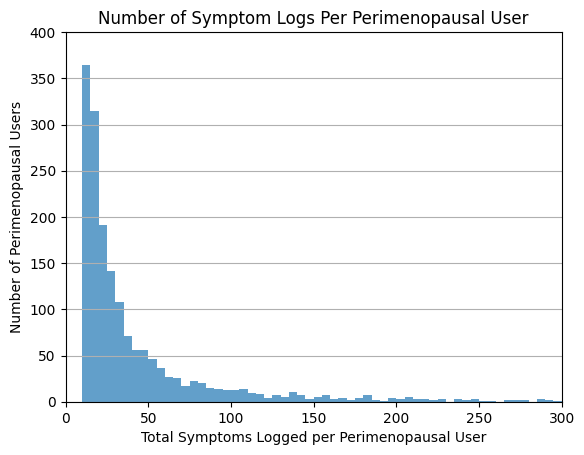

Median Symptoms per User: 24.0
Median Absolute Deviation (MAD) of Symptoms per User: 11.0


In [155]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = unpredictablewvms.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7)
plt.xlabel('Total Symptoms Logged per Perimenopausal User')
plt.ylabel('Number of Perimenopausal Users')
plt.title('Number of Symptom Logs Per Perimenopausal User')
plt.grid(axis='y')
plt.ylim(0,400) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)


## Symptom Frequency by % of Total Symptoms, For Each Symptom

In [156]:
# Calculate the total count of each symptom type (sum across columns)
symptom_totals = unpredictablewvms.sum(axis=0)

# Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Print out each symptom type and its corresponding percentage in the sorted order
c = 0
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
    c += 1
    print(f"{symptom}: {count:.2f}%")
    if c > 100:
        break

hot_flashes: 14.88%
fatigue: 6.14%
night_sweats: 4.83%
headaches: 4.74%
bloating: 4.55%
cramps: 4.38%
anxiety: 4.01%
joint_pain: 3.27%
spotting: 3.09%
brain_fog: 3.04%
allergies: 2.82%
muscle_tension: 2.82%
mood_swings: 2.65%
dry_skin: 2.63%
breast_pain: 2.44%
insomnia: 2.38%
dry_eyes: 2.32%
depression: 2.18%
itchy_skin: 2.01%
brittle_nails: 1.69%
dizzy: 1.68%
facial_hair: 1.63%
sex_drive: 1.37%
hair_loss: 1.37%
chills: 1.35%
incontinence: 1.32%
ringing_ears: 1.32%
memory_lapse: 1.27%
nausea: 1.26%
constipation: 1.25%
diarrhea: 1.22%
tingling_extremeties: 1.22%
heartburn: 1.02%
odor: 0.96%
irregular_beat: 0.96%
breast_swelling: 0.90%
vaginal_dryness: 0.83%
ovulation_pain: 0.55%
vertigo: 0.48%
painful_intercourse: 0.23%
yeast_infection: 0.22%
vomiting: 0.22%
uti: 0.20%
ovulation: 0.20%
nipple_discharge: 0.09%


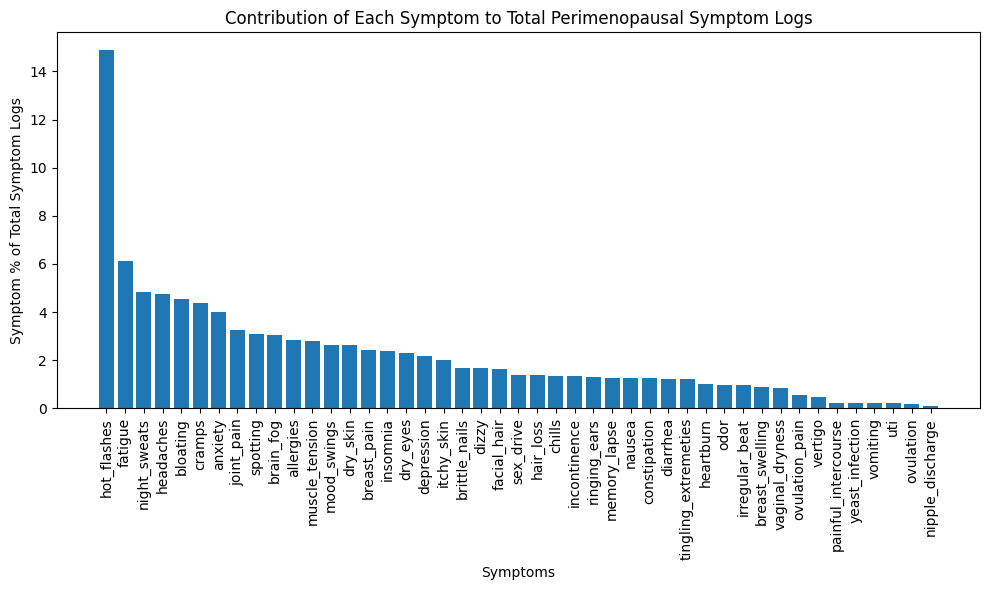

In [157]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Perimenopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Symptom Frequency by % of Users Reporting that Symptom

In [158]:
# Step 1: Calculate the total number of users
total_users = len(unpredictablewvms)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (unpredictablewvms.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

hot_flashes             83.460859
fatigue                 74.573278
night_sweats            62.330783
headaches               59.446733
bloating                59.270159
anxiety                 53.914067
cramps                  52.501471
brain_fog               51.383167
joint_pain              48.734550
insomnia                46.027075
mood_swings             45.791642
dry_skin                41.612713
muscle_tension          39.493820
allergies               39.376104
depression              39.022955
itchy_skin              38.375515
facial_hair             34.255444
breast_pain             33.431430
memory_lapse            32.548558
spotting                32.136551
dry_eyes                32.077693
brittle_nails           31.842260
dizzy                   30.311948
sex_drive               30.253090
constipation            27.427899
hair_loss               27.133608
nausea                  26.015303
tingling_extremeties    25.309005
chills                  24.602707
diarrhea      

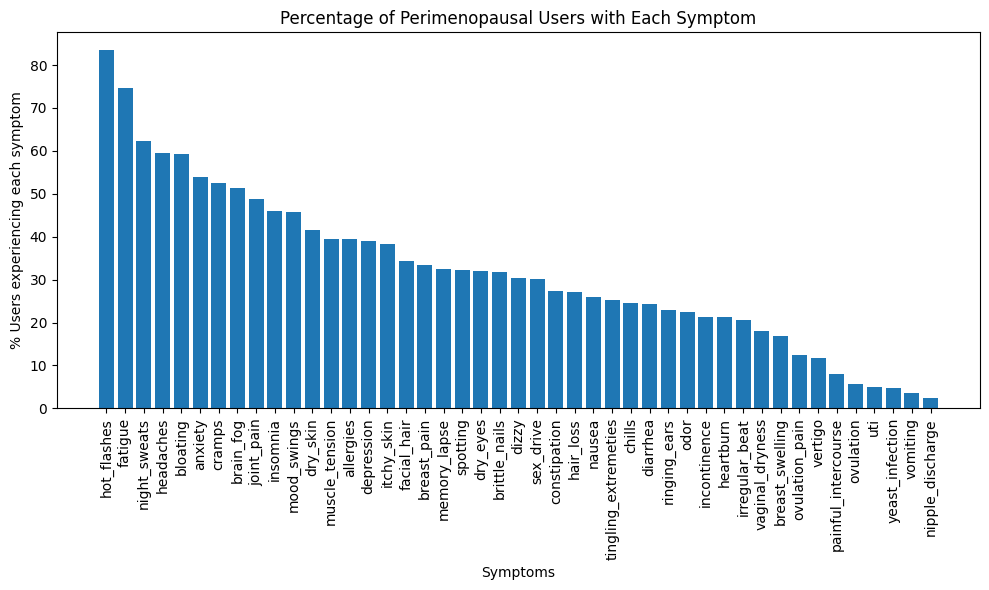

In [159]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Perimenopausal Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [160]:
sframe = unpredictablewvms[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


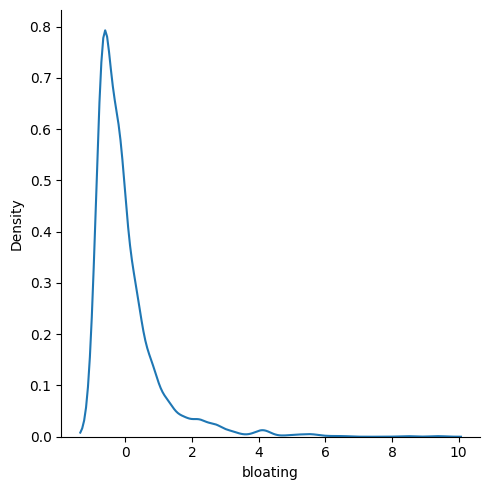

In [45]:
sns.displot(sframe, x='bloating', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


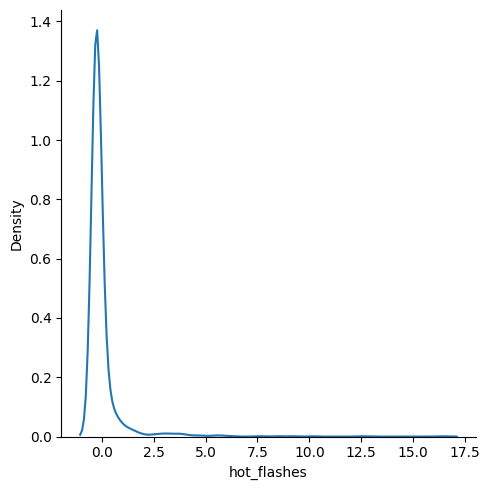

In [46]:
sns.displot(sframe, x='hot_flashes', kind='kde')

In [161]:
cmatrix = sframe.cov()

In [78]:
#cmatrix.to_csv('csv/perimeno_correct_symptom_covariance.csv', index=True)

In [162]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
#fig.write_image('figures/premeno__lenient_symptom_covariance.png')

In [163]:
#Alt covariance plot to properly display y axis titles

import plotly.graph_objs as go
import plotly.express as px

th = 0.6
fmatrix = cmatrix[cmatrix >= th]

# Step 1: Remove 'hot_flashes' and 'night_sweats' from the fmatrix
#fmatrix = fmatrix.drop(['hot_flashes', 'night_sweats'], axis=0)
#fmatrix = fmatrix.drop(['hot_flashes', 'night_sweats'], axis=1)

# Step 2: Sort the covariance matrix in descending order of covariance
sorted_cov_matrix = fmatrix.unstack().sort_values(ascending=False)

# Step 3: Create a bar graph to visualize the covariance by symptom pair
sorted_cov_matrix_df = sorted_cov_matrix.reset_index()
sorted_cov_matrix_df.columns = ['Symptom 1', 'Symptom 2', 'Covariance']

fig = px.bar(sorted_cov_matrix_df,
             x='Symptom 1',
             y='Covariance',
             text='Covariance',
             title='Symptom Covariance',
             labels={'Symptom 1': 'Symptom Pairs', 'Covariance': 'Covariance'},
             width=1024,
             height=600)
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability
fig.show()

# Step 4: Create a dictionary to store the counts of each symptom pair
symptom_pair_counts = {}

# Step 5: Iterate through the sorted DataFrame to count occurrences of each symptom pair
for _, row in sorted_cov_matrix_df.iterrows():
    symptom1 = row['Symptom 1']
    symptom2 = row['Symptom 2']
    covariance = row['Covariance']
    if not (symptom1 == symptom2):
        symptom_pair = f"{symptom1} - {symptom2}"
        count = fmatrix.loc[symptom1, symptom2]
        symptom_pair_counts[symptom_pair] = count

        
# Step 4: Print out the symptom pairs in order from highest to lowest covariance
for _, row in sorted_cov_matrix_df.iterrows():
    symptom1 = row['Symptom 1']
    symptom2 = row['Symptom 2']
    covariance = row['Covariance']
    if not (symptom1 == symptom2):
        print(f'{symptom1} - {symptom2} - {covariance}') #uncomment me to run

allergies - anxiety - nan
allergies - bloating - nan
allergies - brain_fog - nan
allergies - breast_pain - nan
allergies - breast_swelling - nan
allergies - brittle_nails - nan
allergies - chills - nan
allergies - constipation - nan
allergies - cramps - nan
allergies - depression - nan
allergies - diarrhea - nan
allergies - dizzy - nan
allergies - dry_eyes - nan
allergies - dry_skin - nan
allergies - facial_hair - nan
allergies - fatigue - nan
allergies - hair_loss - nan
allergies - headaches - nan
allergies - heartburn - nan
allergies - hot_flashes - nan
allergies - incontinence - nan
allergies - insomnia - nan
allergies - irregular_beat - nan
allergies - itchy_skin - nan
allergies - joint_pain - nan
allergies - memory_lapse - nan
allergies - mood_swings - nan
allergies - muscle_tension - nan
allergies - nausea - nan
allergies - night_sweats - nan
allergies - nipple_discharge - nan
allergies - odor - nan
allergies - ovulation - nan
allergies - ovulation_pain - nan
allergies - painful_

## Find pairs of symptoms with more than 80% corelation.

In [198]:
import pandas as pd
import plotly.express as px

th=0.4

fmatrix = cmatrix[cmatrix >= th]

# create the heatmap with the updated 'fmatrix'
fig = px.imshow(fmatrix,
                width=1024,
                height=1024,
                text_auto=True,
                aspect='auto',
                title='Symptom Covariance')
fig.show()

indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['hot_flashes', 'night_sweats']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))


allergies - bloating - 0.42337266804480367
anxiety - depression - 0.4360802469889796
anxiety - fatigue - 0.473444451016069
bloating - allergies - 0.42337266804480367
bloating - fatigue - 0.431834430847926
brain_fog - fatigue - 0.452419770221125
brain_fog - memory_lapse - 0.4006587101825314
brain_fog - mood_swings - 0.4531388896820659
brittle_nails - dry_skin - 0.40559564584470703
cramps - spotting - 0.40631439258212276
depression - anxiety - 0.4360802469889796
dizzy - fatigue - 0.4561058310956854
dry_skin - brittle_nails - 0.40559564584470703
dry_skin - itchy_skin - 0.4559659143175844
fatigue - anxiety - 0.473444451016069
fatigue - bloating - 0.431834430847926
fatigue - brain_fog - 0.452419770221125
fatigue - dizzy - 0.4561058310956854
fatigue - headaches - 0.49743395401362267
headaches - fatigue - 0.49743395401362267
headaches - muscle_tension - 0.42884349768225183
itchy_skin - dry_skin - 0.4559659143175844
joint_pain - muscle_tension - 0.48531476871389534
memory_lapse - brain_fog - 0

In [166]:
import pandas as pd
import plotly.express as px

th = 0.4

fmatrix = cmatrix[cmatrix >= th]

# create the heatmap with the updated 'fmatrix'
fig = px.imshow(fmatrix,
                width=1024,
                height=1024,
                text_auto=True,
                aspect='auto',
                title='Symptom Covariance')
fig.show()

# Create an empty list to store the results
covariance_results = []

indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['hot_flashes', 'night_sweats']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and calculate the covariance and store the results in the list.
        for p in paired:
            if not (s == p):
                covariance = fmatrix.loc[s][p]
                covariance_results.append({'Symptom1': s, 'Symptom2': p, 'Covariance': covariance})

# Convert the list to a DataFrame
covariance_results_df = pd.DataFrame(covariance_results)

# Sort the DataFrame by the 'Covariance' column in descending order
covariance_results_df = covariance_results_df.sort_values(by='Covariance', ascending=False)

# Print the sorted results
print(covariance_results_df)


           Symptom1         Symptom2  Covariance
19        headaches          fatigue    0.497434
18          fatigue        headaches    0.497434
26   muscle_tension       joint_pain    0.485315
22       joint_pain   muscle_tension    0.485315
2           anxiety          fatigue    0.473444
14          fatigue          anxiety    0.473444
17          fatigue            dizzy    0.456106
11            dizzy          fatigue    0.456106
21       itchy_skin         dry_skin    0.455966
13         dry_skin       itchy_skin    0.455966
7         brain_fog      mood_swings    0.453139
24      mood_swings        brain_fog    0.453139
5         brain_fog          fatigue    0.452420
16          fatigue        brain_fog    0.452420
1           anxiety       depression    0.436080
10       depression          anxiety    0.436080
4          bloating          fatigue    0.431834
15          fatigue         bloating    0.431834
20        headaches   muscle_tension    0.428843
25   muscle_tension 

### Notes

With super users filtered out -- there are MUCH weaker pairwise correlations.

## Cluster Map

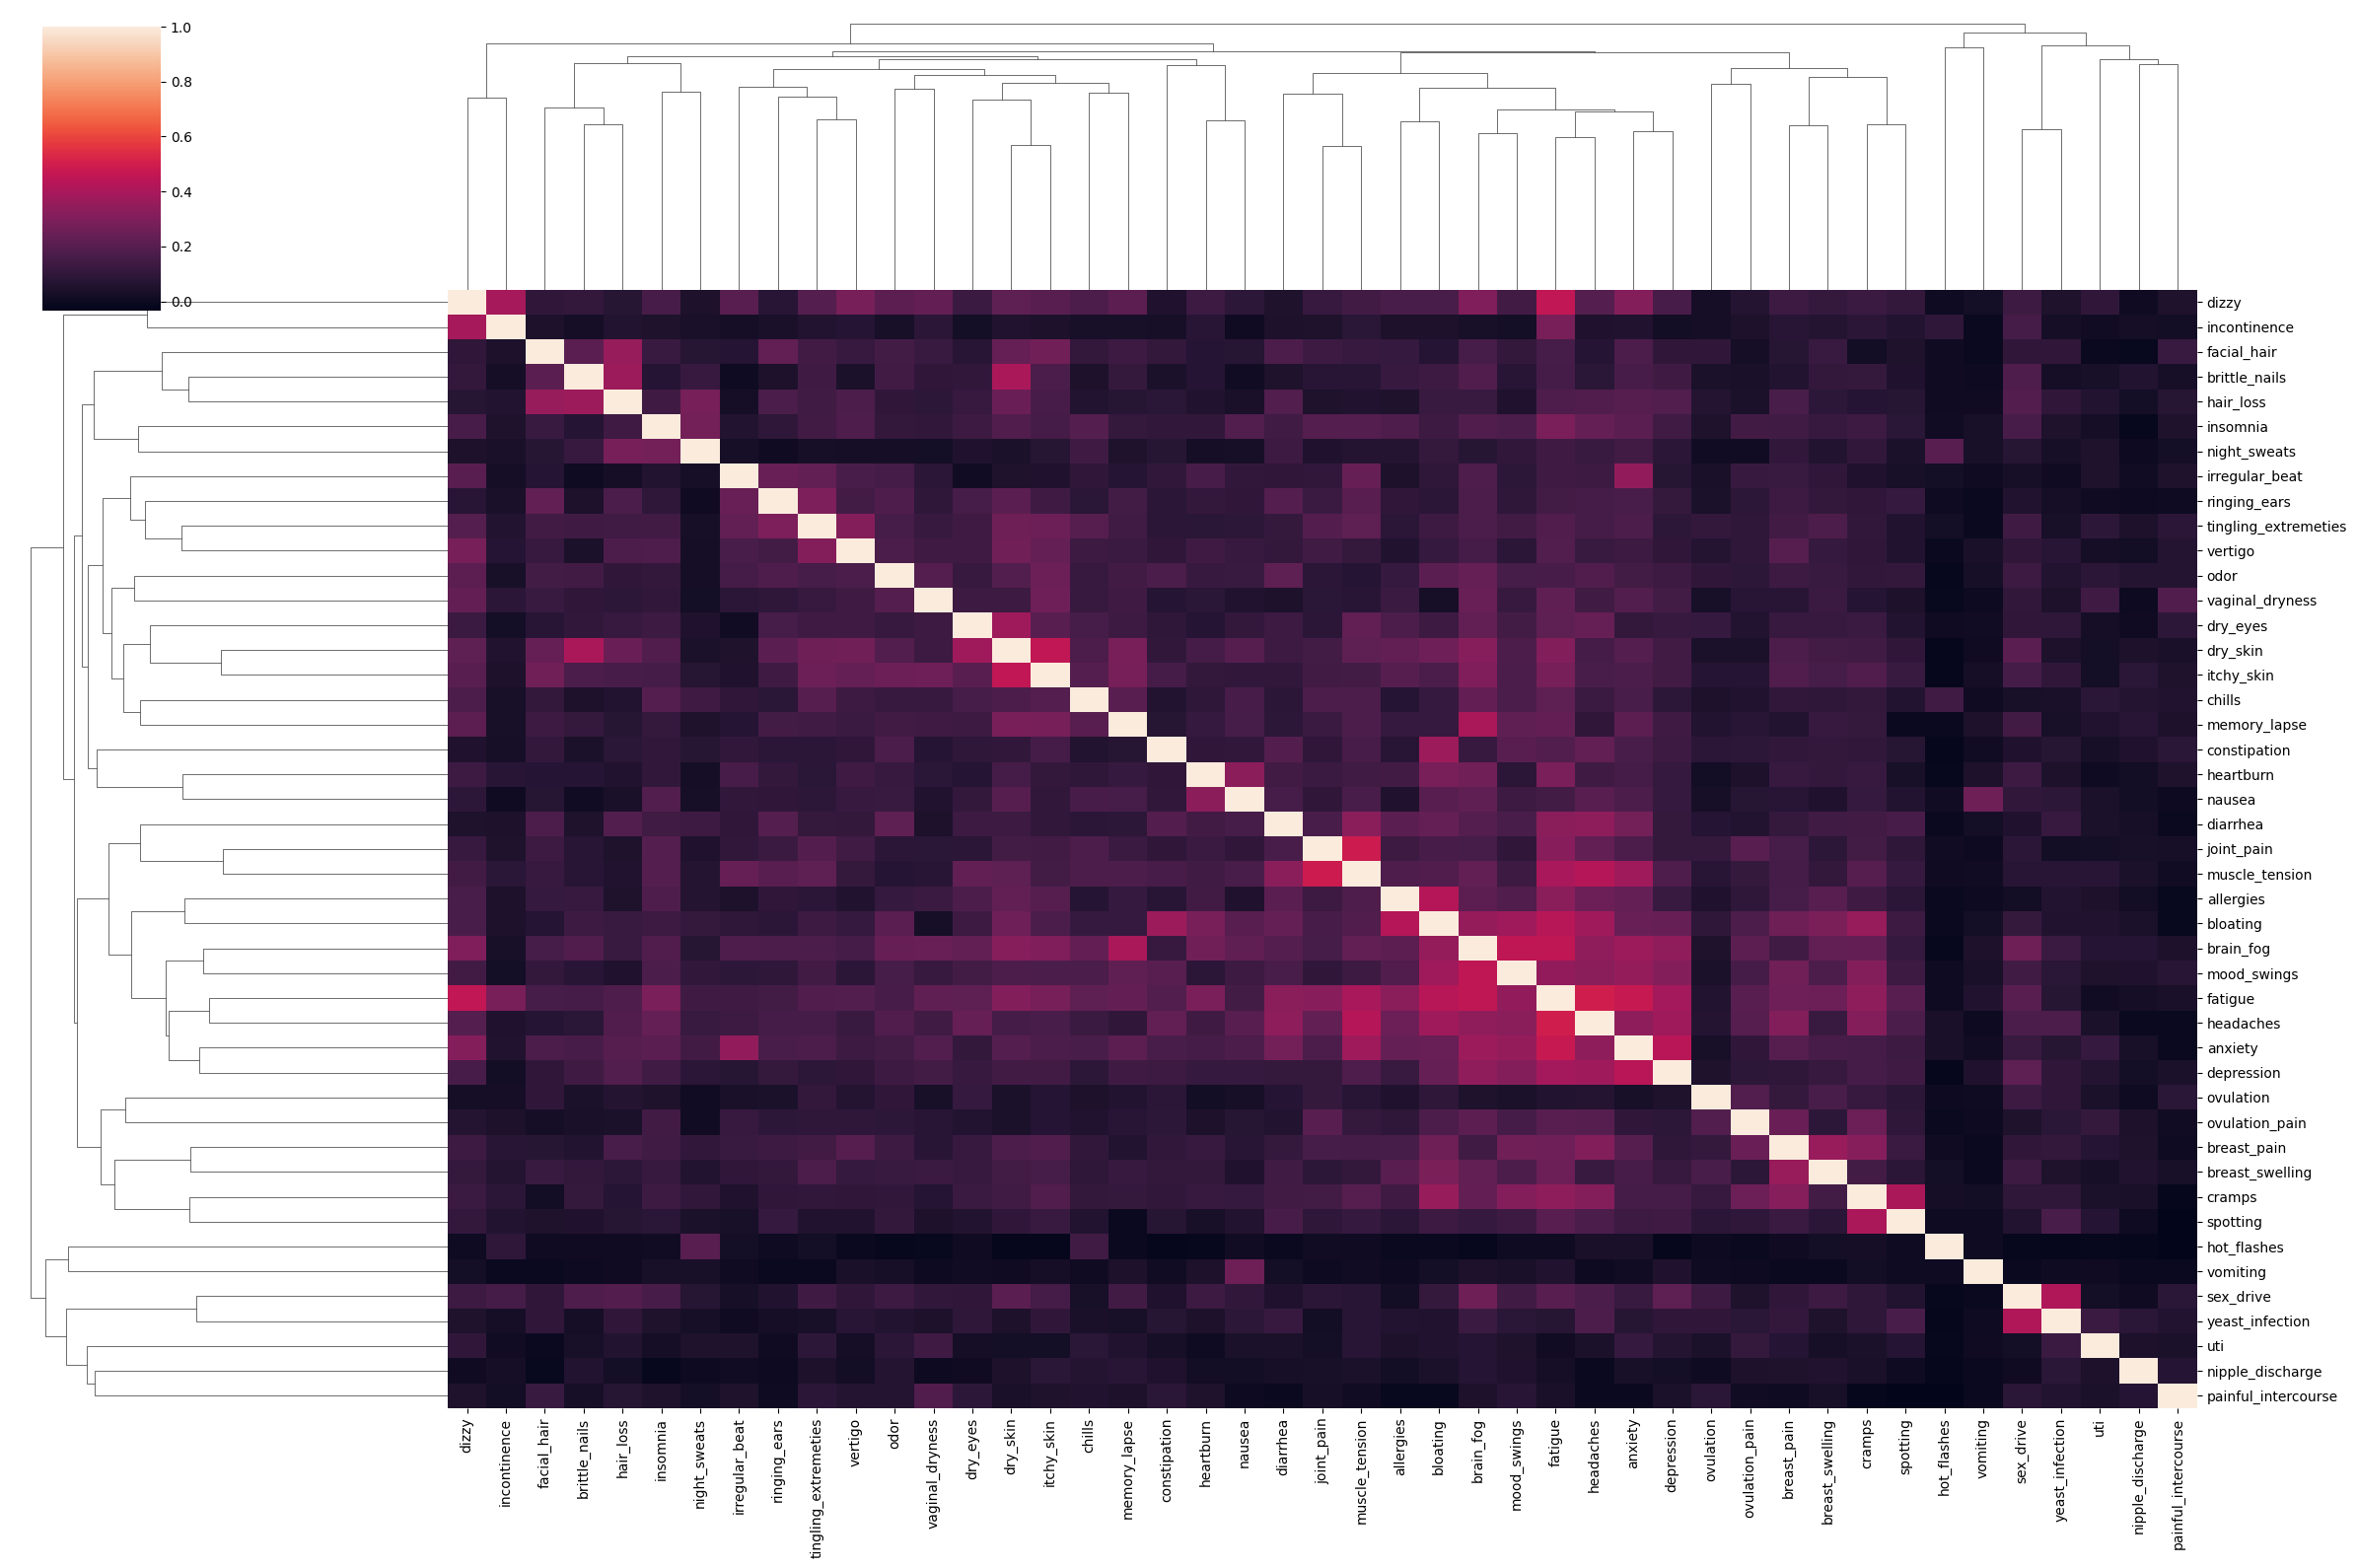

In [167]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [168]:
#Note nothing to see from ARI or DBS. We don't have predetermined labels to compare to. 

# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [169]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)


Optimal number of clusters: 10


In [ ]:
hcluster.savefig('perimeno_symptom_co_hirach.png')

## Perform PCA analysis on the data.

In [170]:
from sklearn.decomposition import PCA

In [171]:
pca = PCA(n_components=15, svd_solver='full')
X = unpredictablewvms[symptoms]

In [172]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [173]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [174]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.58, 0.58
PCA2 - 0.10, 0.68
PCA3 - 0.04, 0.72
PCA4 - 0.03, 0.75
PCA5 - 0.02, 0.77
PCA6 - 0.02, 0.79
PCA7 - 0.02, 0.82
PCA8 - 0.02, 0.83
PCA9 - 0.02, 0.85
PCA10 - 0.01, 0.87
PCA11 - 0.01, 0.88
PCA12 - 0.01, 0.89
PCA13 - 0.01, 0.90
PCA14 - 0.01, 0.91
PCA15 - 0.01, 0.92


Looks like we would need 8 principal components if we wanted to keep 91% of the variance. \
However the 2 components account for the majority of variance (71%), while an 80% variance is represented by 4 components.

In [175]:
pcacomponents = pca.fit_transform(X)

In [176]:
pcacomponents.shape

(1699, 15)

In [177]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [122]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

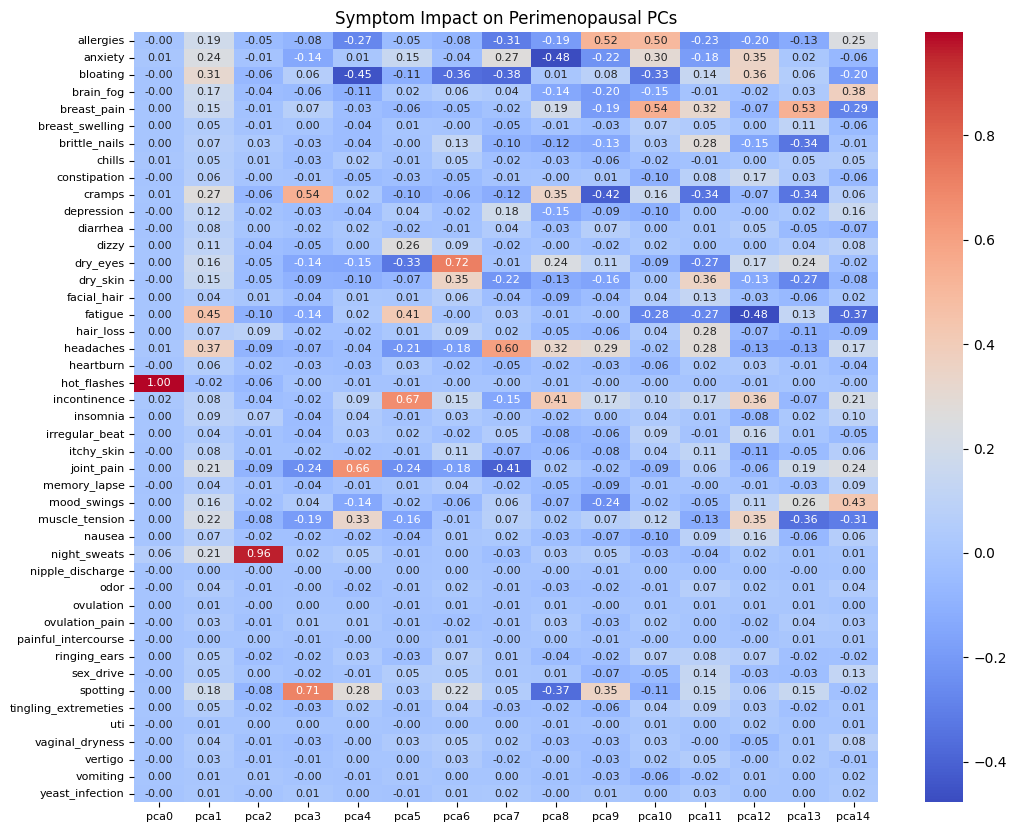

In [179]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using seaborn and matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Perimenopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 90% variance

In [180]:
pca = PCA(n_components=13, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(1699, 13)

In [181]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [182]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

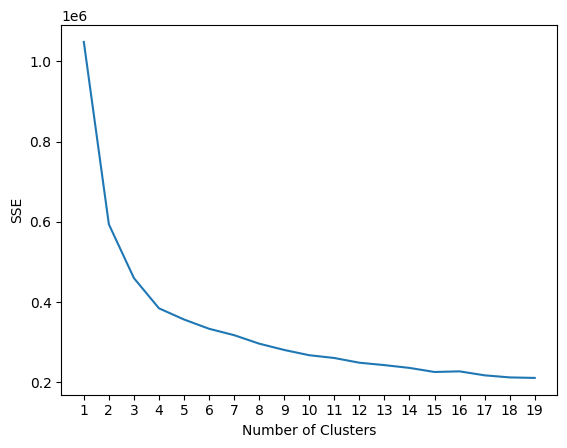

In [183]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [184]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **3**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [185]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

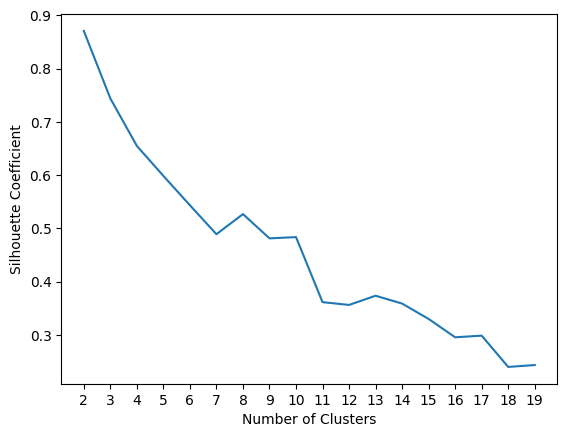

In [186]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [187]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - 

## Cluster them using k-means clustering

In [189]:
kmeans = KMeans(n_clusters=10, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 163
1 - 6
2 - 17
3 - 19
4 - 44
5 - 9
6 - 18
7 - 116
8 - 16
9 - 1291


## Get the users which belong to each of these clusters

In [190]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [191]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [195]:

## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [196]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [197]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['fatigue' 'cramps' 'headaches' 'bloating' 'anxiety']
Segment 1
['night_sweats' 'hot_flashes' 'cramps' 'hair_loss' 'anxiety']
Segment 2
['spotting' 'cramps' 'hot_flashes' 'fatigue' 'breast_pain']
Segment 3
['fatigue' 'bloating' 'headaches' 'allergies' 'anxiety']
Segment 4
['hot_flashes' 'night_sweats' 'headaches' 'cramps' 'fatigue']
Segment 5
['hot_flashes' 'night_sweats' 'cramps' 'headaches' 'fatigue']
Segment 6
['dry_eyes' 'dry_skin' 'fatigue' 'headaches' 'allergies']
Segment 7
['hot_flashes' 'night_sweats' 'bloating' 'fatigue' 'headaches']
Segment 8
['hot_flashes' 'night_sweats' 'incontinence' 'anxiety' 'chills']
Segment 9
['hot_flashes' 'fatigue' 'night_sweats' 'bloating' 'anxiety']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

In [79]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 46
1 - 6
2 - 1486
Segment 0
['hot_flashes' 'night_sweats' 'chills' 'cramps' 'headaches' 'bloating'
 'fatigue' 'joint_pain' 'dry_eyes' 'brain_fog']
Segment 1
['hot_flashes' 'incontinence' 'chills' 'night_sweats' 'headaches'
 'muscle_tension' 'joint_pain' 'diarrhea' 'anxiety' 'insomnia']
Segment 2
['hot_flashes' 'fatigue' 'bloating' 'night_sweats' 'anxiety' 'headaches'
 'cramps' 'joint_pain' 'brain_fog' 'dry_skin']
